# Milestone 2 : Clickstream analysis of Wikipedia
# Introduction
This notebook includes data quality analyses for all the available Wikipedia clickstream datasets through Wikimedia's clickstream data dump as of September 2024.
This is part 1 of my project : cleaning, understanding and visualizing Wikipedia data.

The following studies will look into the size, shape, and structure of the raw datasets; any problems or anomalies will be identified and corrected, and tries out various techniques for data visualization in order to understand the data.

Data taken from :

https://meta.wikimedia.org/wiki/

https://dumps.wikimedia.org/other/clickstream/readme.html

https://en.wikipedia.org/wiki/List_of_Wikipedias#Detailed_list

https://pageviews.wmcloud.org/topviews/?project=en.wikipedia.org&platform=all-access&date=last-month&excludes=

https://stats.wikimedia.org/#/all-projects

In [ ]:
pip install powerlaw #installing powe law library for stats analysis

In [ ]:
# Importing necessary libraries for ths project

import numpy as np  # installing this library for  numerical operations
import pandas as pd  # installing this library for data manipulation and analysis
import requests  # installing this library to send HTTP requests and handling web pages
import re  # Regular expressions for pattern matching in strings
import lxml  # XML and HTML parsing library
from timeit import default_timer as timer  # To measure the runtime of code blocks
from bs4 import BeautifulSoup  # installing this library for web scraping
import powerlaw  # installing this library For statistical analysis


In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# Set the default font size for all plots
plt.rc('font', size=16)

# Create a figure with specific size dimensions
plt.figure(figsize=(20, 10))


<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [ ]:
pd.options.display.max_columns = 25 #setting up for  Pandas options
pd.options.display.max_rows = 50
pd.options.display.precision = 3
pd.options.display.float_format = lambda x: f'{x:.2f}'

In [ ]:
# Utility function to translate ISO language codes into familiar language names
# URL pointing to the CSV file containing ISO language codes and names
iso_language_codes_url = (
    "https://raw.githubusercontent.com/datasets/language-codes/master/data/language-codes.csv"
)

# Load the CSV file into a pandas DataFrame
iso_language_codes_df = pd.read_csv(iso_language_codes_url)

# Function to get the English name of a language using its ISO code
def get_language_name(iso_code):
    # Filter the DataFrame for the row matching the provided ISO code (case insensitive)
    filtered_row = iso_language_codes_df[iso_language_codes_df["alpha2"].str.lower() == iso_code.lower()]

    # Return the English name of the language, or None if no match is found
    # If multiple names are listed, split by ';' and return the first name
    return filtered_row["English"].values[0].split(";")[0] if not filtered_row.empty else None


# Web scrapping the entire wikipedia click stream data

In [ ]:
# Define the base URL to access the clickstream dataset dump page
base_url_clickstream = "https://dumps.wikimedia.org/other/clickstream/"
response = requests.get(base_url_clickstream)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')


In [ ]:
# Extract data from the monthly pages and store file details in a dictionary
# This sends multiple requests to the Wikimedia dump pages, so avoid frequent reruns
datasets = {}
for link in soup.find_all("a"):
    # Check if the link corresponds to a month folder
    if re.match(r"\d{4}-\d{2}/", link['href']):
        month_path = base_url_clickstream + link['href']
        month_response = requests.get(month_path)
        month_page = BeautifulSoup(month_response.text, 'html.parser')
        raw_files_list = str(month_page.find("pre"))

        month_files = {}
        for entry in raw_files_list.split("<a"):
            file_match = re.match(r".*(\w\w)wiki-\d{4}-\d{2}\..*\d\d:\d\d\s*(\d+)", entry)
            if file_match:
                lang_code, size_bytes = file_match.groups()
                month_files[get_language_name(lang_code)] = round(int(size_bytes) / 1000000, 2)

        datasets[link['href'][:-1]] = month_files


In [ ]:
dataset_zipped = pd.DataFrame(datasets).transpose()
dataset_zipped #converting to dataframe

,German,English,Spanish,Japanese,Russian,French,Italian,Polish,Portuguese,Chinese,Persian
2017-11,55.04,311.75,35.22,21.74,32.06,NaN,NaN,NaN,NaN,NaN,NaN
2017-12,54.56,318.82,33.12,21.73,32.04,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,59.43,347.51,35.12,22.03,32.42,38.02,34.86,18.76,16.12,9.34,NaN
2018-02,55.30,310.82,33.88,21.29,31.92,35.45,31.61,17.18,15.64,8.85,NaN
2018-03,59.10,333.40,37.22,23.06,33.74,38.64,33.46,18.10,19.16,11.44,3.46
...,...,...,...,...,...,...,...,...,...,...,...
2024-05,79.09,514.75,60.12,99.58,102.93,63.55,51.46,27.59,23.57,38.06,22.26
2024-06,74.52,487.17,56.20,93.88,94.12,57.17,46.85,26.11,22.38,37.48,22.25
2024-07,77.48,500.83,56.30,95.62,94.67,57.94,47.48,26.77,22.54,38.39,20.35
2024-08,79.24,519.82,59.09,99.20,98.67,61.89,51.41,27.89,23.21,41.66,21.43


In [ ]:
dataset_zipped_stats = dataset_zipped.describe()
print(dataset_zipped_stats) #descriing data

       German  English  Spanish  Japanese  Russian  French  Italian  Polish  \
count   83.00    83.00    83.00     83.00    83.00   81.00    81.00   81.00   
mean    69.14   398.59    49.03     73.84    70.33   52.55    42.40   24.00   
std      6.43    42.58     7.08     26.61    20.46    7.32     4.58    3.18   
min     54.56   310.82    33.12     21.29    31.92   35.45    31.61   16.60   
25%     67.18   380.44    47.82     82.22    67.76   50.62    40.23   23.28   
50%     69.78   394.11    50.89     84.85    76.35   53.76    42.65   24.50   
75%     73.78   419.87    53.02     88.35    82.91   57.28    45.07   26.11   
max     79.54   519.82    60.76     99.58   102.93   67.01    51.46   28.80   

       Portuguese  Chinese  Persian  
count       81.00    81.00    79.00  
mean        20.80    24.31    14.08  
std          2.33     8.63     5.95  
min         15.64     8.85     3.46  
25%         19.50    20.11    11.10  
50%         20.78    24.92    14.73  
75%         22.51    3


# Analyzing  and plotting the sizes of compressed Wikipedia Clickstream datasets

Text(0, 0.5, 'Compressed File Size (MB)')

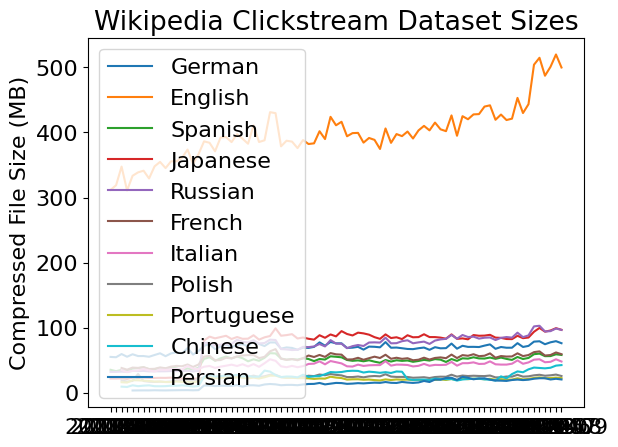

In [ ]:
# Retrieving the current axes object to use for plotting
current_axes = plt.gca()
# Visualizing the compressed dataset sizes on the existing axes
dataset_zipped.plot(ax=current_axes)
# Customize the x-axis ticks to align with the dataset indices
current_axes.set_xticks(np.arange(len(dataset_zipped.index)))
current_axes.set_xticklabels(dataset_zipped.index)
# Adding the  title and ylabel
current_axes.set_title("Wikipedia Clickstream Dataset Sizes")
current_axes.set_ylabel("Compressed File Size (MB)")


# plotting the sizes of compressed Wikipedia Clickstream datasets without english

Text(0, 0.5, 'Compressed File Size (MB)')

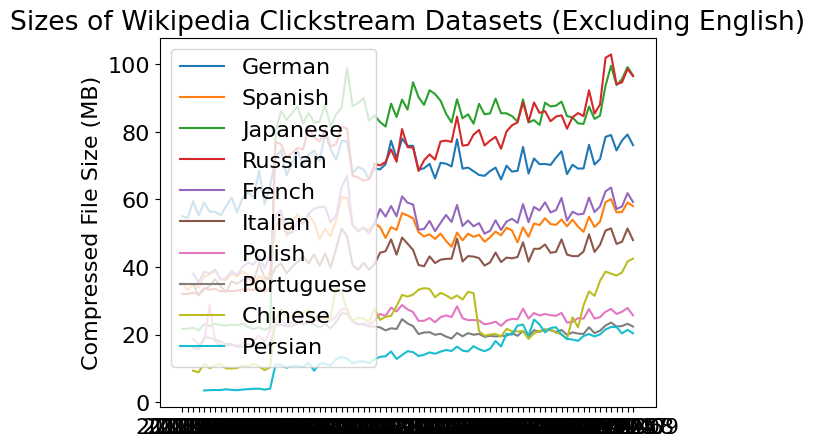

In [ ]:
# Plot the dataset sizes for non-English Wikipedia clickstreams
current_axis = plt.gca()  # Retrieve the current axis for the plot
non_english_data = dataset_zipped.drop(columns='English')  # Remove the English dataset from the data
non_english_data.plot(ax=current_axis)  # Plot the remaining datasets on the existing axis
plt.xticks(ticks=np.arange(len(non_english_data.index)), labels=non_english_data.index)
# Add titles and labels
current_axis.set_title("Sizes of Wikipedia Clickstream Datasets (Excluding English)")
current_axis.set_ylabel("Compressed File Size (MB)")


In [ ]:
# Compute the total size of all compressed files in bytes and convert the result to gigabytes
total_size = sum(dataset_zipped.sum())
total_size_in_GB = total_size / 1000
print("Total size of the compressed files:", total_size_in_GB, "GB") #output


Total size of the compressed files: 69.25845 GB


In [ ]:
# Count the total number of entries in the zipped dataset
total_count = dataset_zipped.count()

# Display the total count of entries
total_count


,0
German,83
English,83
Spanish,83
Japanese,83
Russian,83
French,81
Italian,81
Polish,81
Portuguese,81
Chinese,81


In [ ]:
sum(total_count)

899

# Interpretation nd overview of above code of Clickstream datasets

There exist, at this point in time, 899 Wikipedia clickstream datasets 2017-11 to  2024-09 . The data from November and December 2017 is for five languages. The count increases to 11 till november 2024 . Total size of data till date is 69 gb .

**we dont have enough computational power to analyze 69 gb with multiple languages. So we will be working  on english dataset its huge in size and we can have better understandign of it to analyzie the clickstream data .**.

The datasets are huge. Their sizes are much smaller compared to the German datasets of the English Wikipedia clickstream data, which is much larger in magnitude. Besides, the most numerous clickstream data of sizes in the same order are found in the English Wikipedia. It seems that the clickstream data size in Wikipedia is stable across time; the abnormal growth in clickstream can be noticed for russian, japansese and german apart from english we can see. also from aboev graphs we can inteprepate.

# English wikipedia clickstream Analyses

Let's take a closer look at the unprocessed English Wikipedia clickstream data.

Webscrapping the english dataset

In [ ]:
from timeit import default_timer as timer

# Defining the base URL for accessing the Wikimedia Clickstream dumps
base_url_clickstream = "https://dumps.wikimedia.org/other/clickstream/"
response = requests.get(base_url_clickstream)

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

#Identifing folder links that represent data dumps (structured by year/month)
folders = [a['href'] for a in soup.find_all('a', href=True) if a['href'].startswith('2')]

# Handling the case if no matching folders are found
if not folders:
    raise ValueError("No clickstream folders found. The website structure might have changed.")

# Sorting the folder links by date and select most recent 5
latest_folders = sorted(folders, reverse=True)[:5]

# Forming the URL for the most recent
latest_folder_url = base_url_clickstream + latest_folders[0]
response_latest = requests.get(latest_folder_url)
soup_latest = BeautifulSoup(response_latest.text, 'html.parser')

#Looking  for the English clickstream data file containing 'clickstream-enwiki'
english_file = [a['href'] for a in soup_latest.find_all('a', href=True) if 'clickstream-enwiki' in a['href']][0]

#Combining the base folder URL and the English file name to get the full path to the TSV file
english_file_url = latest_folder_url + english_file

#Loading the clickstream data into a pandas DataFrame
start_time = timer()
df = pd.read_csv(english_file_url, sep='\t', names=['prev', 'curr', 'type', 'n'])
end_time = timer()
print("read_csv runtime:", (end_time - start_time)/60, "min")
print(df.head())


read_csv runtime: 2.8264424533000008 min
            prev                    curr      type          n
0    other-empty               Main_Page  external  119417306
1  Charles_Tilly  Joseph_L._Buttenwieser      link         12
2   other-search  Lyle_and_Erik_Menendez  external   11111073
3  Charles_Tilly         Talcott_Parsons      link         12
4    other-empty            Hyphen-minus  external   10101208


In [ ]:
#df

# Format of data is listed below :

"The structure of the Wikipedia clickstream datasets is outlined here and is expected to be consistent across different language domains and months."

https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream#Format

Format
The current data includes the following 4 fields:

prev: the result of mapping the referrer URL to the fixed set of values described above

curr: the title of the article the client requested

type: describes (prev, curr)

link: if the referrer and request are both articles and the referrer links to the request

external: if the referrer host is not en(.m)?.wikipedia.org

other: if the referrer and request are both articles but the referrer does not link to the request. This can happen when clients search or spoof their refer.

n: the number of occurrences of the (referrer, resource) pair ( The column contains numerical data representing "counts" (the number of clicks or navigations between pages).)

In [ ]:
df.shape #shape of the data : finding rows and columns of datset

(34359342, 4)

In [ ]:
df.info()  # complete information of data
df.describe() # summarization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34359342 entries, 0 to 34359341
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   prev    object
 1   curr    object
 2   type    object
 3   n       int64 
dtypes: int64(1), object(3)
memory usage: 1.0+ GB


,n
count,34359342.00
mean,189.93
std,20775.81
min,10.00
25%,15.00
50%,26.00
75%,66.00
max,119417306.00


In [ ]:
df.describe(include="all") #summarization of every column

,prev,curr,type,n
count,34359310,34359279,34359342,34359342.00
unique,2174287,4848280,3,NaN
top,other-empty,Main_Page,link,NaN
freq,4095316,119848,23122863,NaN
mean,NaN,NaN,NaN,189.93
std,NaN,NaN,NaN,20775.81
min,NaN,NaN,NaN,10.00
25%,NaN,NaN,NaN,15.00
50%,NaN,NaN,NaN,26.00
75%,NaN,NaN,NaN,66.00



Upon reviewing the dataframe summary above, it appears that the counts for the "prev" and "curr" columns are inconsistent. According to the data format guidelines provided by Wikipedia for this dataset, there should be no missing values, which means that the count of values in each column should match the total number of entries in the dataset. Let’s investigate the presence of any missing values in the "prev" and "curr" columns.


In [ ]:
df.dtypes #finding data types of every column

,0
prev,object
curr,object
type,object
n,int64


In [ ]:
len(df[df["prev"].isna()]) #finding out null values

32

In [ ]:
df[df["curr"].isna()] #finding out null values

,prev,curr,type,n
214134,other-search,NaN,external,7050
284488,other-search,NaN,external,5506
400234,other-empty,NaN,external,4056
676930,other-empty,NaN,external,2472
1027081,Main_Page,NaN,other,12
...,...,...,...,...
29747599,Next_Guyanese_general_election,NaN,link,16
30612554,JSON,NaN,link,15
32735855,2024_Istanbul_mayoral_election,NaN,link,13
33198786,Language_transfer,NaN,other,13


In [ ]:
len(df[df["curr"].isna()]) #finding out null values

63

In [ ]:
df.loc[29747599]

,29747599
prev,Next_Guyanese_general_election
curr,NaN
type,link
n,16


Seems that the phrase "NaN" in the raw TSV data indicates a legitimate Wikipedia article title rather than a missing value in the columns: the "NaN" wiki page is real.

We must convert NaN to a string format since Pandas does not accept it as a normal category value, which means it is not included in counts, groups, and other similar actions

In [ ]:
# Remove duplicates
df.drop_duplicates(inplace=True)

Data Reduction from  X million to 1 Million as we have limited computational power to run otherwise system is crashing with ram usage .

Number of outliers detected: 219


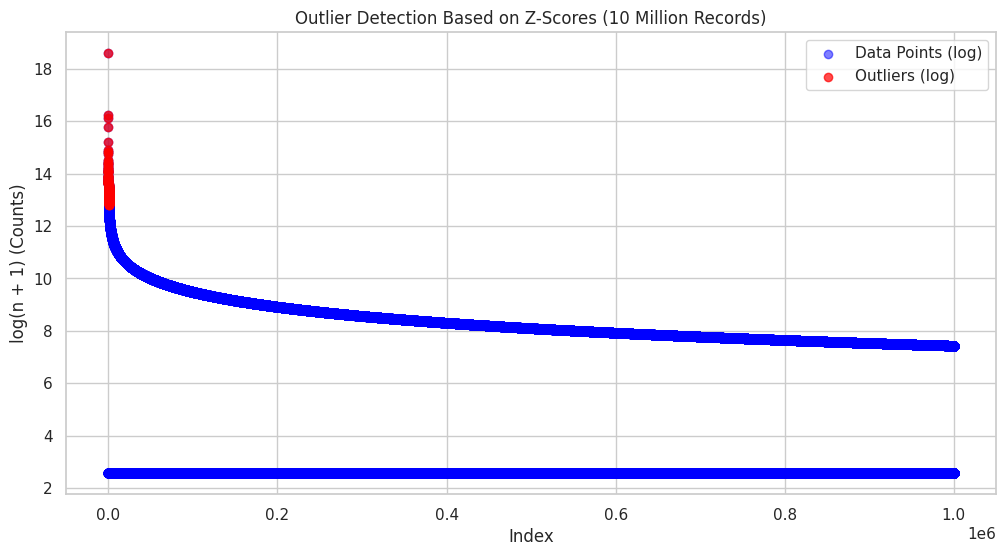

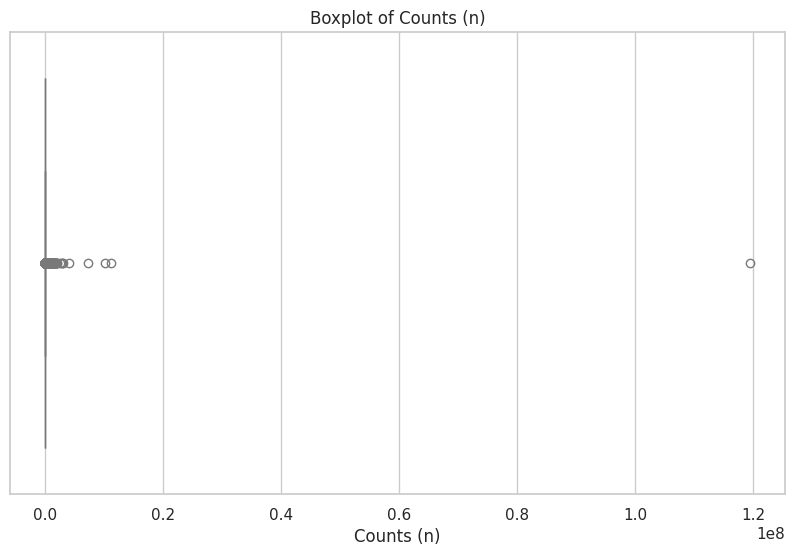

In [ ]:
from scipy import stats
import seaborn as sns


# Taking the first 1 million records for processing
df_subset = df.head(10_000_00)

# Ensuring that there is no NaN values
df_subset = df_subset[~df_subset['n'].isna()]

# Z-scores for the 'n' column in the subset
z_scores = np.abs(stats.zscore(df_subset['n']))
df_subset['z_score'] = z_scores  # Add z-score to DataFrame for reference

# Removing rows with outliers
df_no_outliers = df_subset[z_scores < 3]
num_outliers = len(df_subset) - len(df_no_outliers)
print(f"Number of outliers detected: {num_outliers}")
# Plot the data with outliers
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Scatter plot
plt.scatter(range(len(df_subset)), np.log1p(df_subset['n']), label='Data Points (log)', color='blue', alpha=0.5)
outliers = df_subset[z_scores >= 3]
plt.scatter(outliers.index, np.log1p(outliers['n']), label='Outliers (log)', color='red', alpha=0.7)

# Set labels and title
plt.title('Outlier Detection Based on Z-Scores (10 Million Records)')
plt.xlabel('Index')
plt.ylabel('log(n + 1) (Counts)')
plt.legend()
plt.show()

# Boxplot for visualization of outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_subset['n'], color='lightblue')
plt.title('Boxplot of Counts (n)')
plt.xlabel('Counts (n)')
plt.show()


<ipython-input-26-97c8d32f40b9>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='curr_grouped', data=df_subset, palette='viridis', order=df_subset['curr_grouped'].value_counts().index)


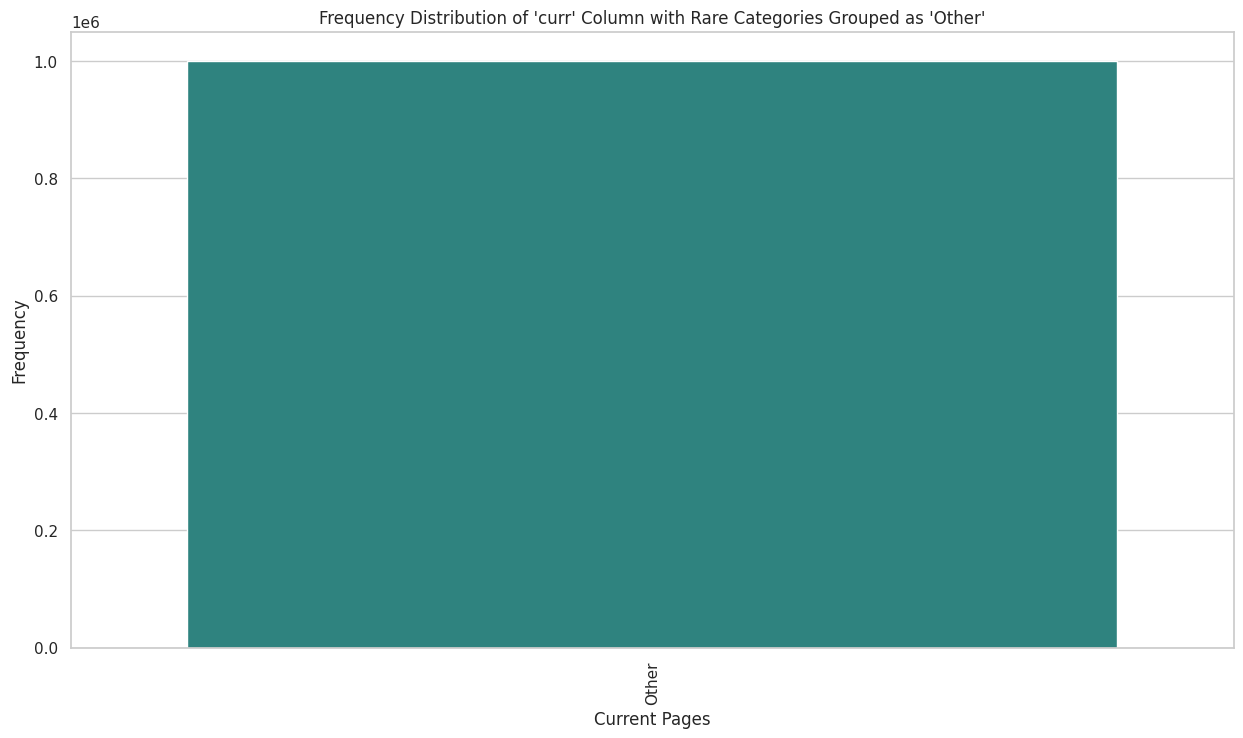

In [ ]:
import seaborn as sns

#Get the frequency counts of the 'curr' column
curr_counts = df_subset['curr'].value_counts()

# Defining the threshold for rare categories
threshold = len(df_subset) * 0.01

# Identifying the are categories
rare_categories = curr_counts[curr_counts < threshold].index

# Replacing the rare categories in the 'curr' column with 'Other'
df_subset['curr_grouped'] = df_subset['curr'].apply(lambda x: 'Other' if x in rare_categories else x)

# plotting the frequency wuth other
plt.figure(figsize=(15, 8))
sns.countplot(x='curr_grouped', data=df_subset, palette='viridis', order=df_subset['curr_grouped'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Frequency Distribution of 'curr' Column with Rare Categories Grouped as 'Other'")
plt.xlabel("Current Pages")
plt.ylabel("Frequency")
plt.show()


<ipython-input-27-445d26da2e67>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prev_grouped', data=df_subset, palette='viridis', order=df_subset['prev_grouped'].value_counts().index)


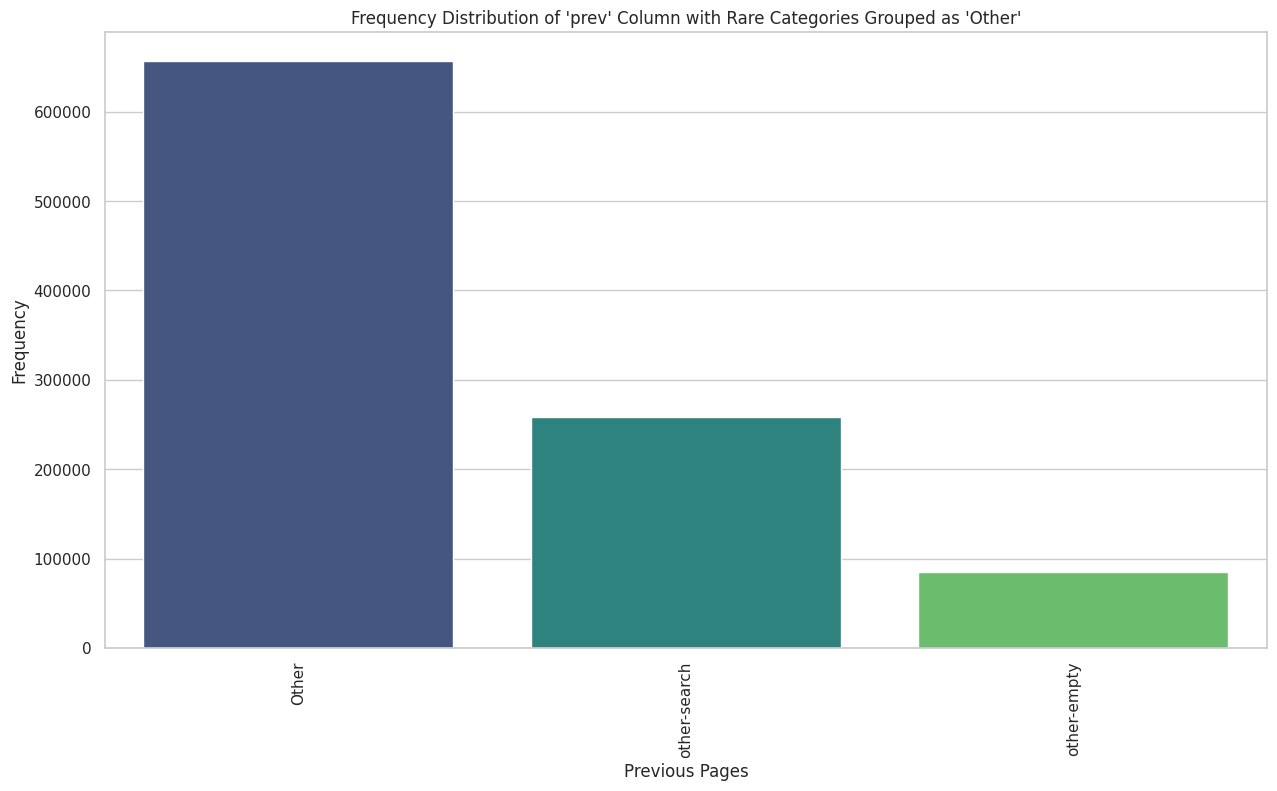

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of unique values in the 'prev' column
prev_counts = df_subset['prev'].value_counts()

# Set a threshold
threshold_prev = len(df_subset) * 0.01

# Identify the categories
rare_prev_categories = prev_counts[prev_counts < threshold_prev].index

# Group the rare categories
df_subset['prev_grouped'] = df_subset['prev'].apply(lambda x: 'Other' if x in rare_prev_categories else x)

# =Visualize the frequency distribution of the 'prev' column by gruping toehther rare categories as 'Other'
plt.figure(figsize=(15, 8))
sns.countplot(x='prev_grouped', data=df_subset, palette='viridis', order=df_subset['prev_grouped'].value_counts().index)

plt.xticks(rotation=90)
plt.title("Frequency Distribution of 'prev' Column with Rare Categories Grouped as 'Other'")
plt.xlabel("Previous Pages")
plt.ylabel("Frequency")
plt.show()


The above table for the description of the dataset ans visualization , seems to be in good alignment with the following details about the format of the data: "no missing values, a substantial amount of unique values both for the 'prev' and 'curr' columns, three variants of type for the link category, and a numerical field for link traffic volume ('n') with a minimum threshold.

Lastly, we will check the distribution of the link traffic volume numbers to ensure that they make sense and eventually find anomalies in the data.

Here , we will identify attribute types (categorical, numerical etc.), have a deeper data understanding (central tendency, dispersion, qq plot), data similarity, normalization etc

**categorical and numerical columns**

It identifies the columns of a DataFrame, df, that are numeric in nature-that is, integers or floats-and the columns that represent categorical data; that is, texts or objects.

The select_dtypes(include=['object']) is used to select columns that have data types as 'object' usually strings,; select_dtypes(include=[np.number]) is used for columns with data types of numerics.

This code will store the column names in the variables categorical_columns and numerical_columns.



In [ ]:
# Identify categorical and numerical columns
categorical_cols = df_subset.select_dtypes(include=['object']).columns
numerical_cols = df_subset.select_dtypes(include=[np.number]).columns
print(df_subset[numerical_cols].mean(), df_subset[numerical_cols].std())
print(df_subset[numerical_cols].median())

n         3769.89
z_score      0.04
dtype: float64 n         121722.90
z_score        1.00
dtype: float64
n         850.50
z_score     0.03
dtype: float64


Here in next steps we will be doing :

1. Central Tendency: Calculate the average and median of n
2. Dispersion: Calculate the variance and standard deviation of n
3. Q-Q plot: Assess whether n follows a normal distribution
4. Data Similarity: The Jaccard similarity between Prev and curr
5. Normalisation: Normalize a value to n within the range of 0 to 1
6. Transformation: Log Transformation of n.


In [ ]:
mean_n = df_subset['n'].mean() # Central Tendency
median_n = df_subset['n'].median()
print(f"Mean of 'n': {mean_n}, Median of 'n': {median_n}")


Mean of 'n': 3769.889938, Median of 'n': 850.5


In [ ]:
# Dispersion
std_n = df_subset['n'].std()
variance_n = df_subset['n'].var()
print(f"Standard Deviation of 'n': {std_n}, Variance of 'n': {variance_n}")

Standard Deviation of 'n': 121722.8974225748, Variance of 'n': 14816463756.946665


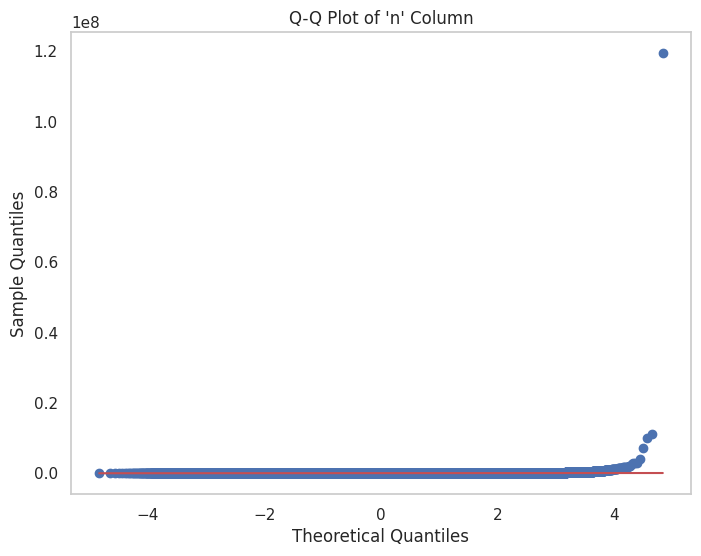

In [ ]:
# Q-Q Plot
import scipy.stats as stats
plt.figure(figsize=(8, 6))
stats.probplot(df_subset['n'], dist="norm", plot=plt)
plt.title("Q-Q Plot of 'n' Column")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

We could compare categorical variables for their similarity using metrics such as Cosine Similarity or the Jaccard Index. In order to simplify our operation we can focus on using the unique values from the prior and curr columns to get the Jaccard similarity of one another.


In [ ]:
# Jaccard Similarity
unique_prev = set(df_subset['prev'])
unique_curr = set(df_subset['curr'])
jaccard_index = len(unique_prev.intersection(unique_curr)) / len(unique_prev.union(unique_curr))
print(f"Jaccard Similarity between 'prev' and 'curr': {jaccard_index}")


Jaccard Similarity between 'prev' and 'curr': 0.19797074732231534


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
scaler = MinMaxScaler()
df_subset['n_normalized'] = scaler.fit_transform(df_subset[['n']])

# Log Transformation
df_subset['n_log'] = np.log1p(df_subset['n'])

# Display transformed DataFrame
print(df_subset[['n', 'n_normalized', 'n_log']].head())

           n  n_normalized  n_log
0  119417306          1.00  18.60
1         12          0.00   2.56
2   11111073          0.09  16.22
3         12          0.00   2.56
4   10101208          0.08  16.13


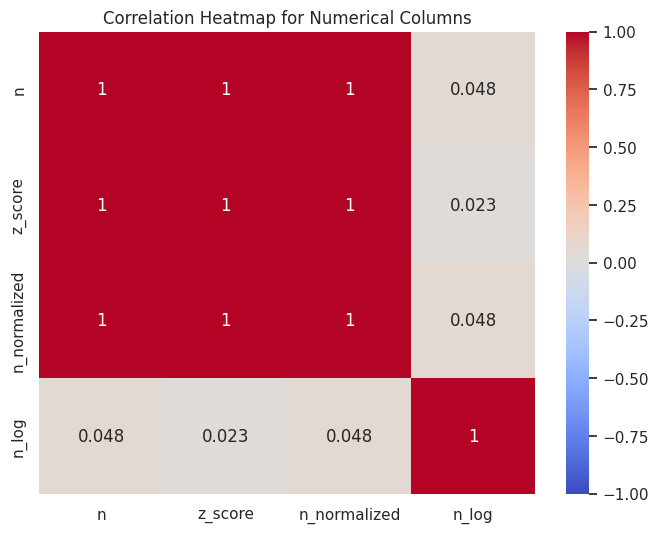

In [ ]:
#heatmap correlation
plt.figure(figsize=(8, 6))
# The numeric_only parameter ensures that only numerical columns are used for correlation calculation.
corr_matrix = df_subset.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Numerical Columns')
plt.show()


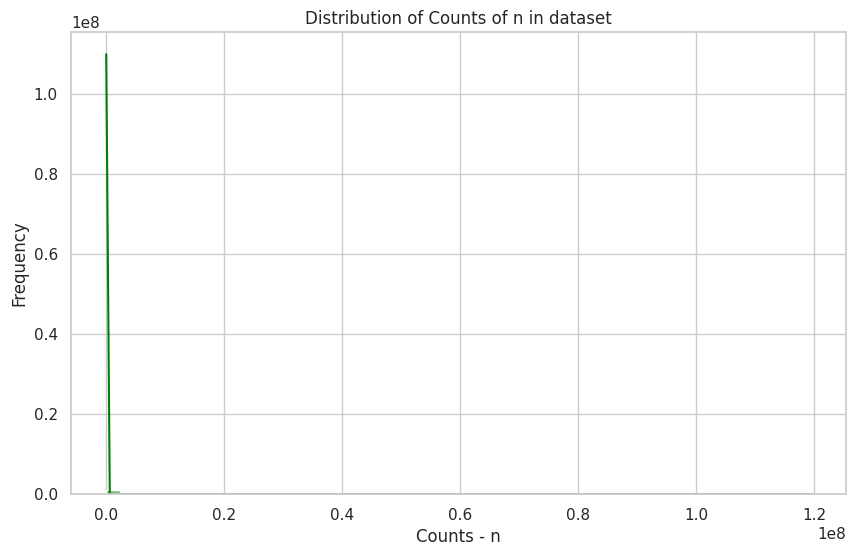

In [ ]:
#Distribution Plot (Histogram) for n column (counts):
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['n'], bins=50, color='green', kde=True)
plt.title('Distribution of Counts of n in dataset')
plt.xlabel('Counts - n')
plt.ylabel('Frequency')
plt.show()

<ipython-input-35-71f27f23c578>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=prev_top10.index, y=prev_top10.values, palette='viridis')


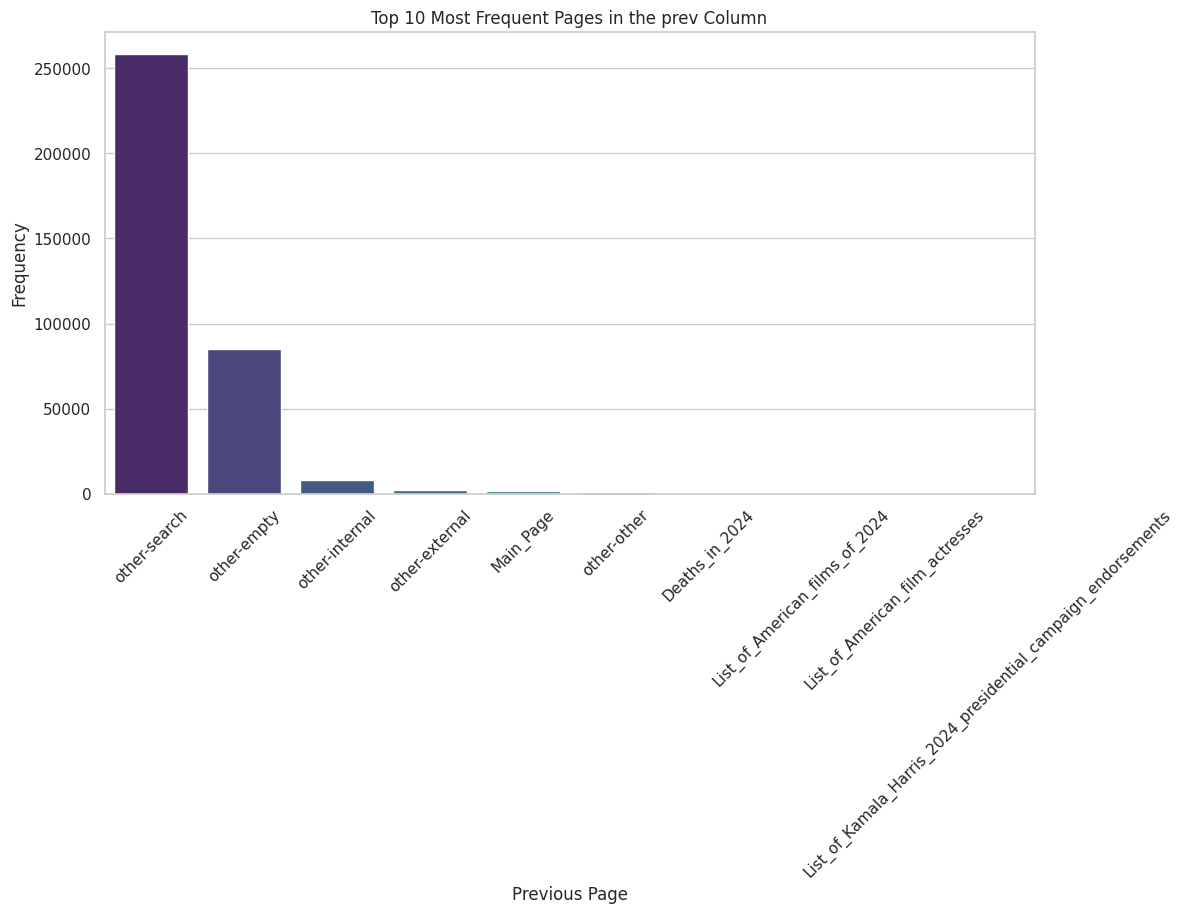

In [ ]:
#The plot is used to identify the 10 most common entries in the prev column
plt.figure(figsize=(12, 6))
prev_top10 = df_subset['prev'].value_counts().nlargest(10)
sns.barplot(x=prev_top10.index, y=prev_top10.values, palette='viridis')
plt.title('Top 10 Most Frequent Pages in the prev Column')
plt.xticks(rotation=45)
plt.xlabel('Previous Page')
plt.ylabel('Frequency')
plt.show()


This bar plot provides information about the most popular sources of user navigation on Wikipedia by rapidly identifying which pages in the prev column are generating the most user traffic (as previous pages). Understanding user behavior and trends can benefit from it. A comparison of frequencies is also provided by the bar plot, which highlights the earlier pages that received the most visits.


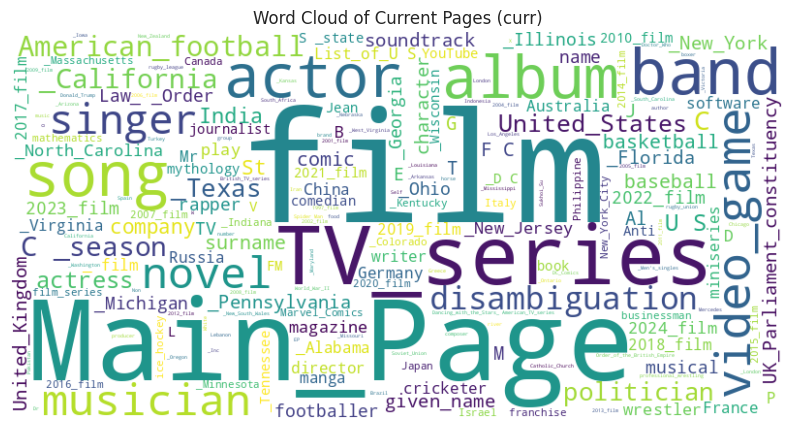

In [ ]:
#Word Cloud for curr Columns:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Convert the 'curr' column to strings before joining
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_subset['curr'].astype(str)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Current Pages (curr)')
plt.show()

By looking at the words that are bigger in the cloud, you can easily determine which sites are the most popular in the curr column like film , main page, tv_series , actor , album song . It offers a high-level summary of the sites that visitors visit the most frequently, providing information on the most popular material on Wikipedia or other platforms that are relevant to your data.


<ipython-input-37-95a04d45b8eb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=curr_top10.index, y=curr_top10.values, palette='coolwarm')


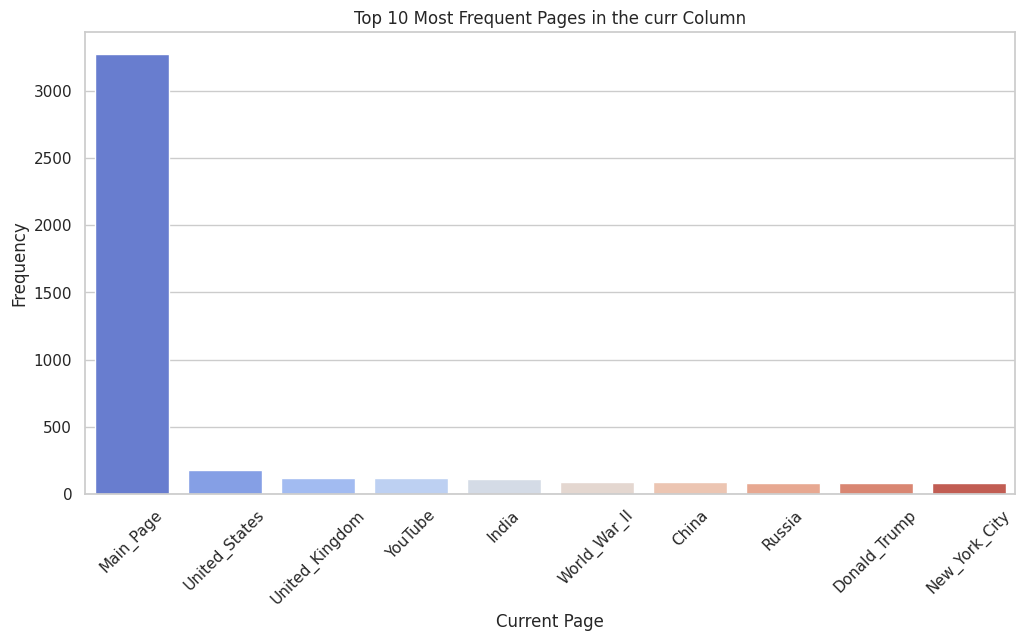

In [ ]:
#This visualization is a bar plot that displays the Top 10 most frequent pages in the curr column
plt.figure(figsize=(12, 6))
curr_top10 = df_subset['curr'].value_counts().nlargest(10)
sns.barplot(x=curr_top10.index, y=curr_top10.values, palette='coolwarm')
plt.title('Top 10 Most Frequent Pages in the curr Column')
plt.xticks(rotation=45)
plt.xlabel('Current Page')
plt.ylabel('Frequency')
plt.show()


The most frequently accessed or browsed pages or articles on Wikipedia (or any dataset with a comparable structure) is revealed by this  barplto. In order to prioritize content optimization or analyze user behavior, it assists in identifying high-traffic sites.


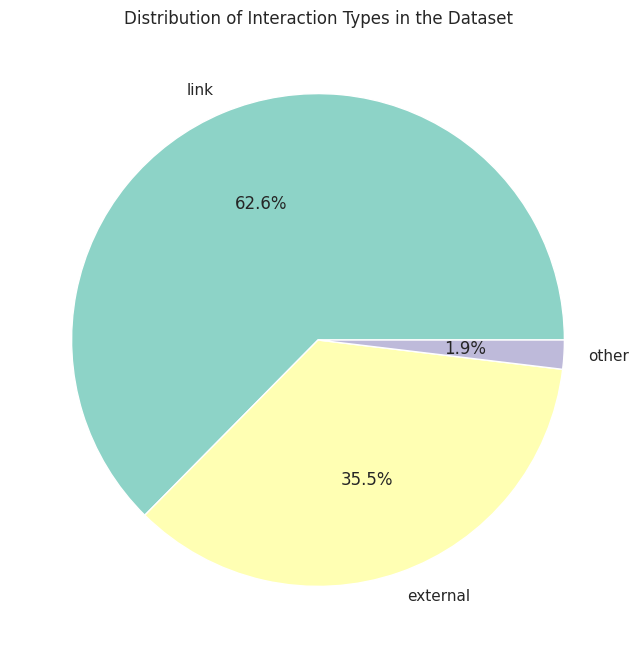

In [ ]:
#pie chart that illustrates the distribution of interaction types in the dataset for the type column.
plt.figure(figsize=(8, 8))
df_subset['type'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title('Distribution of Interaction Types in the Dataset')
plt.ylabel('')
plt.show()


According to the pie chart, links takes the greatest percentage of interactions in the dataset with 62.6% . This implies that rather than visiting other websites, visitors are more likely to move inside Wikipedia and connect to other pages.External connections make up a significant amount of the dataset after internal linkages. Given how frequently visitors are sent to external content for further information, this emphasizes the value of outside resources in the context of Wikipedia articles.


Text(0, 0.5, 'Frequency of Occurrence')

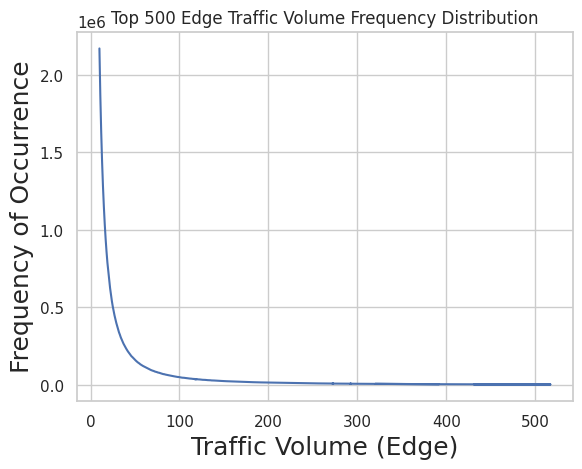

In [ ]:
# Plot the top 500 edge traffic frequencies as a line chart with grid enabled
traffic_counts = df["n"].value_counts()
traffic_line_chart = traffic_counts.head(500).plot.line(
    title="Top 500 Edge Traffic Volume Frequency Distribution", grid=True
)
# Set the x and y axis labels with appropriate font sizes
traffic_line_chart.set_xlabel('Traffic Volume (Edge)', fontsize=18)
traffic_line_chart.set_ylabel('Frequency of Occurrence', fontsize=18)


Above, the frequency distribution is long-tailed: there were high values infrequently and low values very frequently. In other words, most page-to-page connections were visited only a very few times, but a relative few were visited many times.
This is what we would expect from network data, especially in social networks of activity. Popular subjects are likely to be searched on Wikipedia, so when they become popular, more will follow.


Text(0.5, 1.0, 'Log-Scale Distribution of Edge Traffic Frequencies')

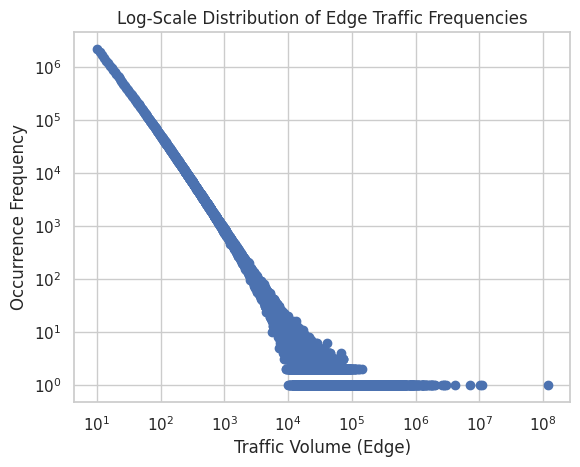

In [ ]:
# Creating a scatter plot
plt.scatter(traffic_counts.index, traffic_counts.values)

# Seting logarithmic scale for both x and y axes
plt.xscale("log")
plt.yscale("log")
# Adding labels and grid for better readability
plt.xlabel('Traffic Volume (Edge)')
plt.ylabel('Occurrence Frequency')
plt.grid(True)
plt.title("Log-Scale Distribution of Edge Traffic Frequencies")


While the higher link traffic volume values fan out, the lower link traffic volume values in the log-log figure above resemble anything approaching a line. It would be challenging to place a line here because the higher volume traffic figures are messier. The use of logarithmic binning can help with this. Using the powerlaw package, we may attempt to fit a powerlaw.


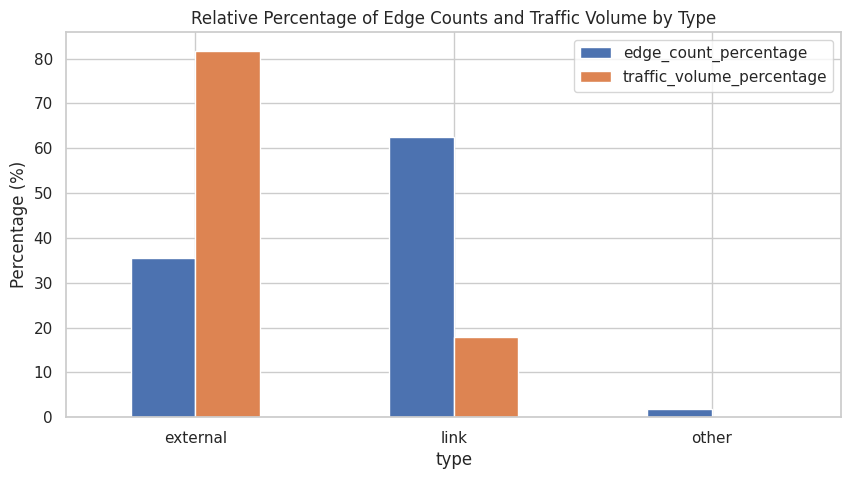

In [ ]:
# Sorting the DataFrame by traffic volume ('n') in descending order
sorted_df = df_subset.sort_values(by="n", ascending=False)
top_20_records = sorted_df.head(20)

# Computing the count of edge types by grouping by 'type'
edge_type_counts = sorted_df.groupby("type")["n"].count()
edge_type_counts.rename("edge_count", inplace=True)

# Calculating the total traffic volume for each edge type
total_traffic_by_type = sorted_df.groupby("type")["n"].sum()
total_traffic_by_type.rename("traffic_volume", inplace=True)

# Combining the  edge counts and traffic volumes into a summary DataFrame
type_summary = pd.concat([edge_type_counts, total_traffic_by_type], axis=1)

# Computeing the percentage share of edge counts and traffic volume for each type
type_summary["edge_count_percentage"] = type_summary["edge_count"] / type_summary["edge_count"].sum()
type_summary["traffic_volume_percentage"] = type_summary["traffic_volume"] / type_summary["traffic_volume"].sum()

pd.options.display.float_format = '{:.2f}'.format

type_summary

# Create a bar chart
ax = plt.gca()
(type_summary[["edge_count_percentage", "traffic_volume_percentage"]] * 100).plot(kind="bar", ax=ax)


plt.xticks(np.arange(len(type_summary.index)), type_summary.index, rotation=0)
ax.set_title("Relative Percentage of Edge Counts and Traffic Volume by Type")
ax.set_ylabel("Percentage (%)")


fig = plt.gcf()
fig.set_size_inches(10, 5)


An external reference type (an external website, an external search, another Wikimedia project, or an empty referer) accounts for around 82% of the visitor flow. Article-to-article links account for 19% of the traffic flow, while "other" reference types (occurring when the request and the referer are both Wikipedia articles but not connected) make up the remaining 1%. Internal searches from a Wikipedia article page are included in the "other" reference category.

Given that those referers are grouped into categories, the external reference type's comparatively low edge count is not shocking.


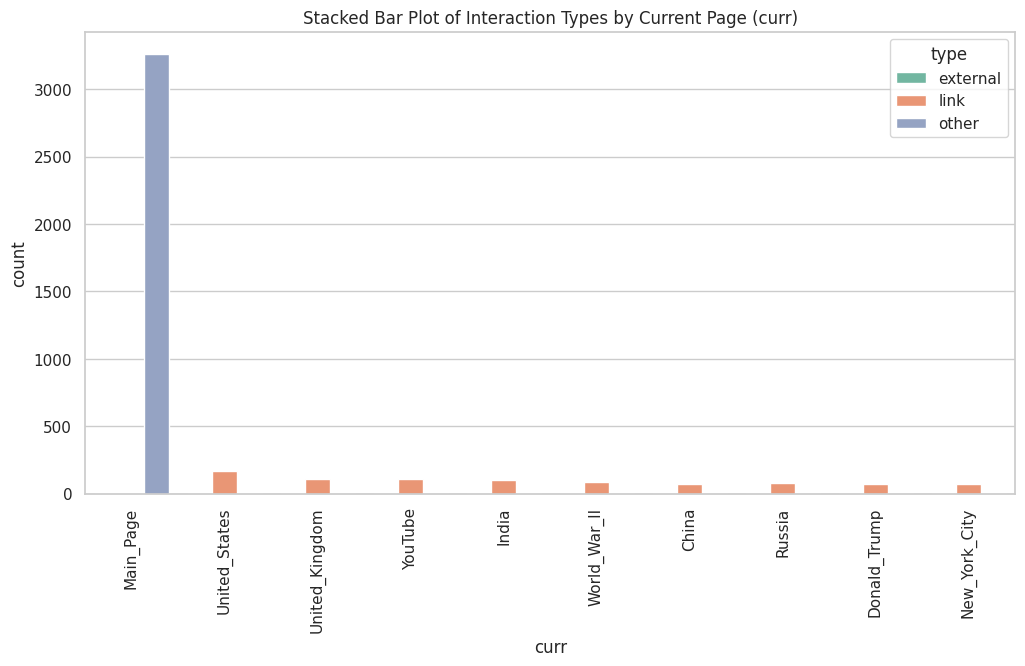

In [ ]:
plt.figure(figsize=(12, 6)) #Stacked Bar Plot for type vs curr
sns.countplot(x='curr', hue='type', data=df_subset, palette='Set2', order=curr_top10.index)
plt.xticks(rotation=90)
plt.title('Stacked Bar Plot of Interaction Types by Current Page (curr)')
plt.show()


It is easy to see which sites now have the most interactions like mainpage and how those interactions are grouped by category with the use of the stacked bar plot.It reveals patterns, such if some pages now have more external connections than internal ones, or whether a certain kind of interaction is more prevalent on particular sites.It will be readily apparent as a shorter bar if there is currently very little activity on any page.


<ipython-input-43-3543661ac103>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df_subset['type'], y=df_subset['n'], palette='Set1', scale='width')
<ipython-input-43-3543661ac103>:3: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x=df_subset['type'], y=df_subset['n'], palette='Set1', scale='width')


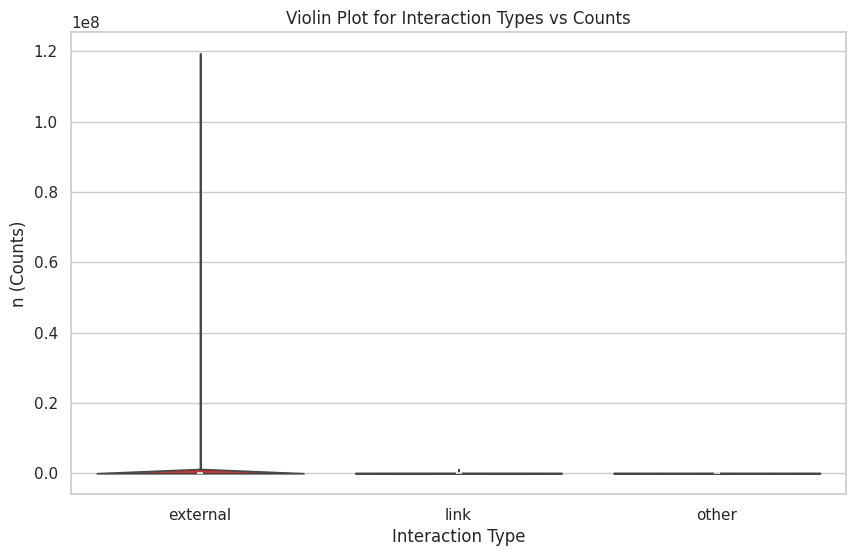

In [ ]:
#violin ploy
plt.figure(figsize=(10, 6))
sns.violinplot(x=df_subset['type'], y=df_subset['n'], palette='Set1', scale='width')
plt.title('Violin Plot for Interaction Types vs Counts')
plt.xlabel('Interaction Type')
plt.ylabel('n (Counts)')
plt.show()
